# 1. Imports and Setup

In this cell, we import all the necessary libraries and set up the working environment.


In [ ]:
import json
import os
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, CSVLogger, ModelCheckpoint

2024-09-17 11:35:54.860260: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-17 11:36:29.175351: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
# Function to load configuration from a JSON file
def load_config(filename: str = "config.json") -> dict:
    """
    Loads the configuration from a JSON file.

    Parameters:
    - filename (str): The path to the configuration file.

    Returns:
    - dict: Configuration parameters loaded from the JSON file.
    """
    with open(filename, 'r') as f:
        return json.load(f)

# Load configuration
config = load_config()

In [ ]:
### Configuration and Parameters
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE
INPUT_SHAPE = (32, 32, 3)
EPOCHS = config["unet"]["decoder"]["training"]["epochs"]

### Paths
# Define directories for data and results
data_dir = "/media/neurone-pc6/Volume/Michele/Prog_GAF_Michele/pythonProject/data/RGB"
label_0_folder = os.path.join(data_dir, "Label_0")
label_1_folder = os.path.join(data_dir, "Label_1")
results_dir = 'results'
models_dir = 'models'
logger_path = os.path.join(results_dir, 'classification_rgb.log')
model_save_path = os.path.join(models_dir, 'classification_rgb.h5')

#Definizione di ottimizzatore,loss e metriche
OPTIMIZER = tf.keras.optimizers.get({
    "class_name": config["unet"]["training"]["optimizer"],
    "config": {
        "learning_rate": config["unet"]["training"]["learning_rate"]
    }
})

LOSS = config["unet"]["decoder"]["training"]["loss"] ,
METRICS = config["unet"]["decoder"]["metrics"]

#Definizione dei callbacks
classification_model_checkpoint = ModelCheckpoint(
    filepath='models/classification_gadf_checkpoint.h5',  # Specifica un nome di file diverso per il checkpoint
    monitor=config["unet"]["training"]["model_checkpoint"]["monitor"],
    save_best_only=config["unet"]["training"]["model_checkpoint"]["save_best_only"]
)

classification_early_stopping = EarlyStopping(
    monitor=config["unet"]["training"]["early_stopping"]["monitor"],
    patience=config["unet"]["training"]["early_stopping"]["patience"],
    restore_best_weights=config["unet"]["training"]["early_stopping"]["restore_best_weights"]
)

classification_reduce_lr = ReduceLROnPlateau(
    monitor=config["unet"]["training"]["lr_scheduler"]["monitor"],
    factor=config["unet"]["training"]["lr_scheduler"]["factor"],
    patience=config["unet"]["training"]["lr_scheduler"]["patience"]
)

classification_csv_logger = CSVLogger('results/classification_rgb.log')

# 2. Utility Functions

In this section, we define the utility functions for loading configuration, data, and creating the CNN model.


In [ ]:
# Function to create a DataFrame with image paths and labels
def create_dataframe(label_0_folder, label_1_folder):
    """
    Create a DataFrame mapping image paths to their labels.

    Args:
        label_0_folder (str): Path to folder containing class 0 images.
        label_1_folder (str): Path to folder containing class 1 images.

    Returns:
        pd.DataFrame: DataFrame with columns ["image_path", "label"].
    """
    data = []
    for filename in os.listdir(label_0_folder):
        img_path = os.path.join(label_0_folder, filename)
        data.append((img_path, 0))

    for filename in os.listdir(label_1_folder):
        img_path = os.path.join(label_1_folder, filename)
        data.append((img_path, 1))

    df = pd.DataFrame(data, columns=["image_path", "label"])
    return shuffle(df).reset_index(drop=True)

# Function to preprocess and load classification images
def load_and_preprocess_image_classification(image_path, label):
    """
    Load and preprocess an image for classification.

    Args:
        image_path (str): Path to the image file.
        label (int): Label corresponding to the image.

    Returns:
        tf.Tensor, int: Processed image tensor and its label.
    """
    def _load_image(image_path):
        image = np.load(image_path.decode('utf-8'))
        image = image.astype(np.float32)  # Assicurati che i dati siano float32
        return image

    # Carica e normalizza l'immagine
    image = tf.numpy_function(_load_image, [image_path], tf.float32)
    image.set_shape([32, 32, 3])
    
    # Normalizzazione dei pixel da [0, 255] a [0, 1]
    image = image / 255.0
    
    return image, label

# 3 Dataset creation

In [ ]:
### Create DataFrame
# Map image paths to labels
df = create_dataframe(label_0_folder, label_1_folder)
df["label"] = df["label"].astype(np.float32)

# Split into training, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

### TensorFlow Datasets
# Prepare TensorFlow datasets for training, validation, and testing
train_ds_classification = tf.data.Dataset.from_tensor_slices((train_df["image_path"].values, train_df["label"].values))
train_ds_classification = train_ds_classification.map(load_and_preprocess_image_classification, num_parallel_calls=AUTOTUNE)
train_ds_classification = train_ds_classification.batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds_classification = tf.data.Dataset.from_tensor_slices((val_df["image_path"].values, val_df["label"].values))
val_ds_classification = val_ds_classification.map(load_and_preprocess_image_classification, num_parallel_calls=AUTOTUNE)
val_ds_classification = val_ds_classification.batch(BATCH_SIZE).prefetch(AUTOTUNE)

test_ds_classification = tf.data.Dataset.from_tensor_slices((test_df["image_path"].values, test_df["label"].values))
test_ds_classification = test_ds_classification.map(load_and_preprocess_image_classification, num_parallel_calls=AUTOTUNE)
test_ds_classification = test_ds_classification.batch(1).prefetch(AUTOTUNE)


# 5. Model Training and Evaluation

We will now train the Cnn model and evaluate it on the test data.


In [ ]:
# Passi di train e validation
STEPS_PER_EPOCH = tf.data.experimental.cardinality(train_ds_classification).numpy()
VALIDATION_STEPS = tf.data.experimental.cardinality(val_ds_classification).numpy()

In [ ]:
# Load pre-trained U-Net model
unet_model = load_model('models/u-net_rgb.h5')

def create_classification_model(base_model: Model, dense_units: int = 256, dropout_rate: float = 0.5) -> Model:
    """
    Creates a classification model on top of a pre-trained base model (e.g., U-Net).

    Parameters:
    - base_model (Model): The pre-trained model to use as a base.
    - dense_units (int): Number of units in the dense layer.
    - dropout_rate (float): Dropout rate for regularization.

    Returns:
    - Model: The classification model.
    """
    # Freeze encoder layers
    for layer in base_model.layers[:-9]:
        layer.trainable = False

    # Add classification head
    flatten_layer = layers.Flatten()(base_model.output)
    dense_layer = layers.Dense(dense_units, activation='relu', 
                               kernel_regularizer=tf.keras.regularizers.l2(0.001))(flatten_layer)
    dropout_layer = layers.Dropout(dropout_rate)(dense_layer)
    output_layer = layers.Dense(1, activation='sigmoid')(dropout_layer)

    return models.Model(inputs=base_model.input, outputs=output_layer)

In [ ]:
def train_model(model: Model, train_ds: tf.data.Dataset, val_ds: tf.data.Dataset, 
                epochs: int, optimizer: tf.keras.optimizers.Optimizer, 
                loss: str, metrics: list[str], callbacks: list[tf.keras.callbacks.Callback]) -> tf.keras.callbacks.History:
    """
    Compiles and trains a model.

    Parameters:
    - model (Model): The model to train.
    - train_ds (tf.data.Dataset): The training dataset.
    - val_ds (tf.data.Dataset): The validation dataset.
    - epochs (int): Number of epochs to train the model.
    - optimizer (tf.keras.optimizers.Optimizer): The optimizer to use for training.
    - loss (str): The loss function to use for training.
    - metrics (list[str]): A list of metrics to evaluate during training.
    - callbacks (list[tf.keras.callbacks.Callback]): A list of callbacks to use during training.

    Returns:
    - tf.keras.callbacks.History: The history object containing the training details.
    """
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=val_ds,
        callbacks=callbacks
    )
    
    return history

def evaluate_and_save_results(model: Model, test_ds: tf.data.Dataset, metrics: list[str], results_dir: str) -> None:
    """
    Evaluates the model on the test dataset and saves the results to a file.

    Parameters:
    - model (Model): The trained model to evaluate.
    - test_ds (tf.data.Dataset): The test dataset.
    - metrics (list[str]): A list of metrics to include in the evaluation.
    - results_dir (str): Directory to save the evaluation results.
    """
    test_results = model.evaluate(test_ds)

    print("Test Loss:", test_results[0])
    print("Test Accuracy:", test_results[1])

    test_results_path = os.path.join(results_dir, 'test_results_classification_rgb.txt')
    with open(test_results_path, 'w') as f:
        f.write(f"Test Loss: {test_results[0]}\n")
        for i, metric in enumerate(metrics):
            f.write(f"Test {metric}: {test_results[i + 1]}\n")

In [ ]:
# Create classification model
classification_model = create_classification_model(unet_model, dense_units=256, dropout_rate=0.5)

In [15]:
classification_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 32)   9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 16, 32)   0           ['conv2d_1[0][0]']               
                                                                                              

In [ ]:
# Train the classification model
classification_history = train_model(
    model=classification_model,
    train_ds=train_ds_classification,
    val_ds=val_ds_classification,
    epochs=EPOCHS,
    optimizer=OPTIMIZER,
    loss=LOSS,
    metrics=METRICS,
    callbacks=[classification_early_stopping, classification_model_checkpoint, classification_reduce_lr, classification_csv_logger]
)

In [ ]:
# Evaluate and save the results
evaluate_and_save_results(
    model=classification_model,
    test_ds=test_ds_classification,
    metrics=METRICS,
    results_dir=results_dir
)

2024-07-29 11:11:15.338231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [24000]
	 [[{{node Placeholder/_1}}]]
2024-07-29 11:11:15.338401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [24000]
	 [[{{node Placeholder/_1}}]]


24000/24000 [==============================] - 49s 2ms/step - loss: 0.0122 - binary_accuracy: 0.9965


# 6. Data visualization

In [ ]:
# Define a function to calculate and plot the confusion matrix
def plot_confusion_matrix(test_ds, model, class_labels):
    """
    Calculate and plot the confusion matrix with percentages for a classification model.

    Parameters:
    - test_ds (Dataset): A dataset containing test image batches and their corresponding labels.
    - model (Model): The trained classification model.
    - class_labels (list): A list of strings representing class labels for the confusion matrix.

    Returns:
    - cm (ndarray): The confusion matrix as a 2D numpy array.
    - cm_percent (ndarray): The confusion matrix with percentages as a 2D numpy array.
    """
    # Collect ground truth labels (y_true) and model predictions (y_pred)
    y_true = []
    y_pred = []

    for image_batch, label_batch in test_ds:
        predictions = model.predict(image_batch)
        y_true.extend(label_batch.numpy())  # Append ground truth labels
        y_pred.extend([round(pred.item()) for pred in predictions])  # Append rounded predictions

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate percentage for each cell relative to the total samples for that class
    cm_percent = cm / cm.sum(axis=1, keepdims=True) * 100

    # Plot the confusion matrix with both absolute numbers and percentages
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)

    # Add percentages to the heatmap
    for i in range(len(cm)):
        for j in range(len(cm)):
            plt.text(j + 0.25, i + 0.5, f'{cm_percent[i][j]:.2f}%', 
                     ha='center', va='center', color='black')

    # Set axis labels and title
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix (with Percentages)')
    plt.show()

    return cm, cm_percent

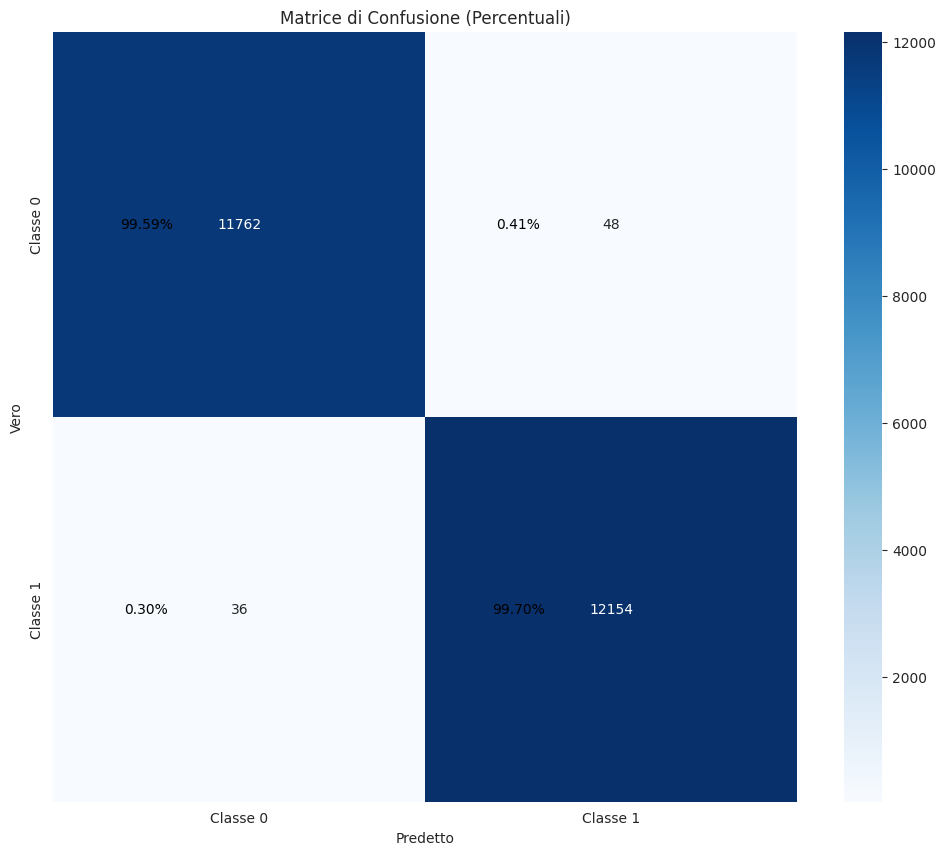

In [ ]:
class_labels = ['Class 0', 'Class 1']
cm, cm_percent = plot_confusion_matrix(test_ds_classification, classification_model, class_labels)

# 6. Model Saving

After training, we save the trained model.


In [ ]:
def save_model(model: Model, model_save_path: str) -> None:
    """
    Saves the trained model to the specified path.

    Parameters:
    - model (Model): The trained model to save.
    - model_save_path (str): Path where the model will be saved.
    """
    # Save the model to the specified path
    model.save(model_save_path)
    print(f"Model saved to {model_save_path}")

# Save the trained model
save_model(classification_model, model_save_path)